# Goal:
For now we will focus on part 2 of the arbitrage case study (https://drive.google.com/file/d/1TjTJnOmPHKKS2rrhyJTiPaymqk4Wra2K/view?usp=sharing).

Our goal is to determine:

#### 2.1: Does Arbitrage Exist?

Graph trade prices of assets on Binance vs. Poloniex, and calculate price differentials between exchanges

#### 2.2: The Duration of Arbitrage

How long do **large** price differentials exist before prices converge?

#### 2.3: Driving Factors of Arbitrage

Factors such as liquidity disparities, trading volumes, market inefficiencies, news events, and regulatory
changes can contribute to price differentials across exchanges.

**Aside**: One way to take advantage of cross-exchange arbitrage is to create limit orders that rest in the order book of a less liquid exchange (like Poloniex). When those orders are executed, close the arbitrage on a more liquid exchange (like Binance) where the spread is lower, to take advantage of arbitrage from liquidity differences.

However, keep in mind transaction costs (exchange fees, the bid-ask spread, transfer fees, or borrow rates for shorting or hedging) may make it difficult to take advantage of price differences across exchanges. The column `sell2` may be useful for simulating the cost of crossing the book to execute an arbitrage (see data dictionary below). For now it may also be easier to ignore these costs, and only look at them at the end.

If we have time, we can also examine other exchanges or determine optimal inventory allocations to take advantage of arbitrage opportunities.

In [ ]:
# install libraries if needed
!pip install mysql-connector-python
!pip install pandas
!pip install numpy
!pip install matplotlib

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import datetime

# Import Data
`Binance-Poloniex-Hugh.parquet` contains all trades for the following tickers on August 15, 2022 on Binance and Poloniex. You can download this file from: https://drive.google.com/file/d/1qOTpV-9AHIJozVsGAIe-qPM2YnZPWcsX/view?usp=sharing

Note that these tickers are different than from the case study, because the case study assets are missing data for this date (since they weren't yet listed on Poloniex). So I just chose these assets to analyze.

`['btc-usdt', 'eth-usdt', 'xrp-usdt', 'doge-usdt', 'bch-usdt', 'tru-usdt', 'aave-usdt']`

## Data Dictionary
* datetime: (str) date string in UTC time
* time: (int) timestamp in milliseconds
* price: (float) price of the asset in terms of the quote currency (i.e. usdt)
* amount: (float) the volume of the trade in terms of the base asset (i.e. btc)
* exchange: (str) Exchange code. We care about “bnce” (Binance) and “polo” (Poloniex)
* instrmnt: (str) the base-quote pair, i.e. btc-usdt or eth-usdt, etc. I've filtered these to include only the tickers listed above, but you can query your own from the database using `download.ipynb`.
* vol_dllr: (float) volume in quote currency (i.e. usdt)
* sell2: (bool / int): If 1, it means the taker was a sell order, i.e. the trade was initiated by a market sell order. If 0, the trade was initiated by a market buy order.

In [3]:
# Download the file from https://drive.google.com/file/d/1qOTpV-9AHIJozVsGAIe-qPM2YnZPWcsX/view?usp=sharing
trades = pd.read_parquet("Binance-Poloniex-Hugh.parquet")

In [4]:
trades

,time,price,amount,exchange,instrmnt,vol_dllr,sell2,asset
datetime,,,,,,,,
2022-08-15 00:00:00.000999,1.660522e+12,1935.32,0.03080,bnce,eth-usdt,59.607856,0.0,eth
2022-08-15 00:00:00.000999,1.660522e+12,1935.31,0.00950,bnce,eth-usdt,18.385445,1.0,eth
2022-08-15 00:00:00.001999,1.660522e+12,24305.25,0.00063,bnce,btc-usdt,15.312308,1.0,btc
2022-08-15 00:00:00.004000,1.660522e+12,24307.02,0.00073,bnce,btc-usdt,17.744125,0.0,btc
2022-08-15 00:00:00.007000,1.660522e+12,1935.31,0.01850,bnce,eth-usdt,35.803235,1.0,eth
...,...,...,...,...,...,...,...,...
2022-08-15 23:59:59.993999,1.660608e+12,24094.82,0.00057,bnce,btc-usdt,13.734047,0.0,btc
2022-08-15 23:59:59.996000,1.660608e+12,1899.06,0.04520,bnce,eth-usdt,85.837512,0.0,eth
2022-08-15 23:59:59.996000,1.660608e+12,1899.06,0.04340,bnce,eth-usdt,82.419204,0.0,eth


## Data Visualizations
First, lets try graphing the trade prices on each exchange for some various assets. You'll notice smaller coins like `aave-usdt` often have more price differences than larger coins like `eth-usdt`.

Note that graphing larger coins may take longer as there are more trades to graph. It is only feasible to graph since we have one day's of data only.

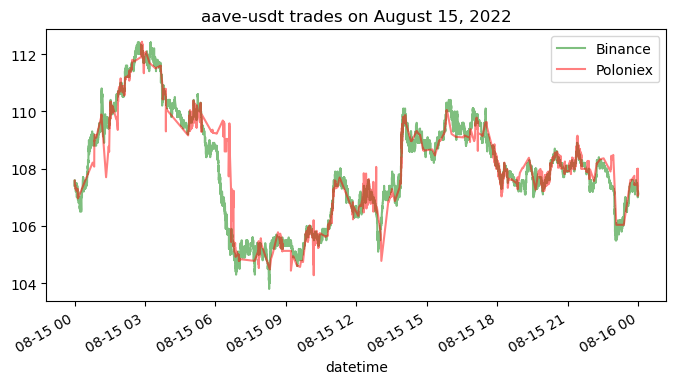

In [57]:
ticker = 'aave-usdt'

# Filter for trades
bnce = trades[(trades.instrmnt == ticker) & (trades.exchange == 'bnce')]
polo = trades[(trades.instrmnt == ticker) & (trades.exchange == 'polo')]

# Plot
fig, ax = plt.subplots(figsize=(8,4))
bnce.price.plot(ax=ax, color='g', alpha=0.5, label="Binance")  # Alpha is used to make line transparent
polo.price.plot(ax=ax, color='r', alpha=0.5, label="Poloniex")

plt.title(f"{ticker} trades on August 15, 2022")
plt.legend(loc="best")

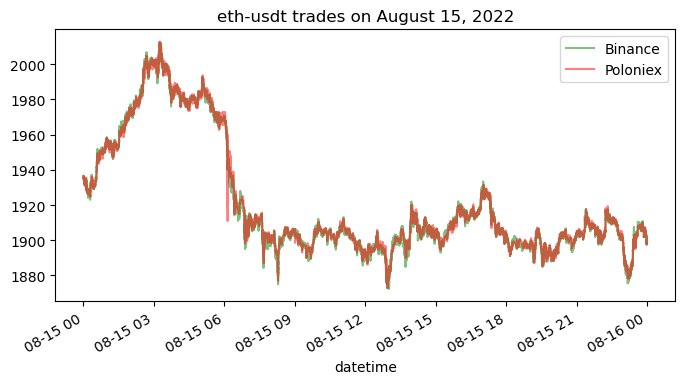

In [55]:
ticker = 'eth-usdt'

# Filter for trades
bnce = trades[(trades.instrmnt == ticker) & (trades.exchange == 'bnce')]
polo = trades[(trades.instrmnt == ticker) & (trades.exchange == 'polo')]

# Plot
fig, ax = plt.subplots(figsize=(8,4))
bnce.price.plot(ax=ax, color='g', alpha=0.5, label="Binance")  # Alpha is used to make line transparent
polo.price.plot(ax=ax, color='r', alpha=0.5, label="Poloniex")

plt.title(f"{ticker} trades on August 15, 2022")
plt.legend(loc="best")

Plot some trades for multiple tickers side-by-side.

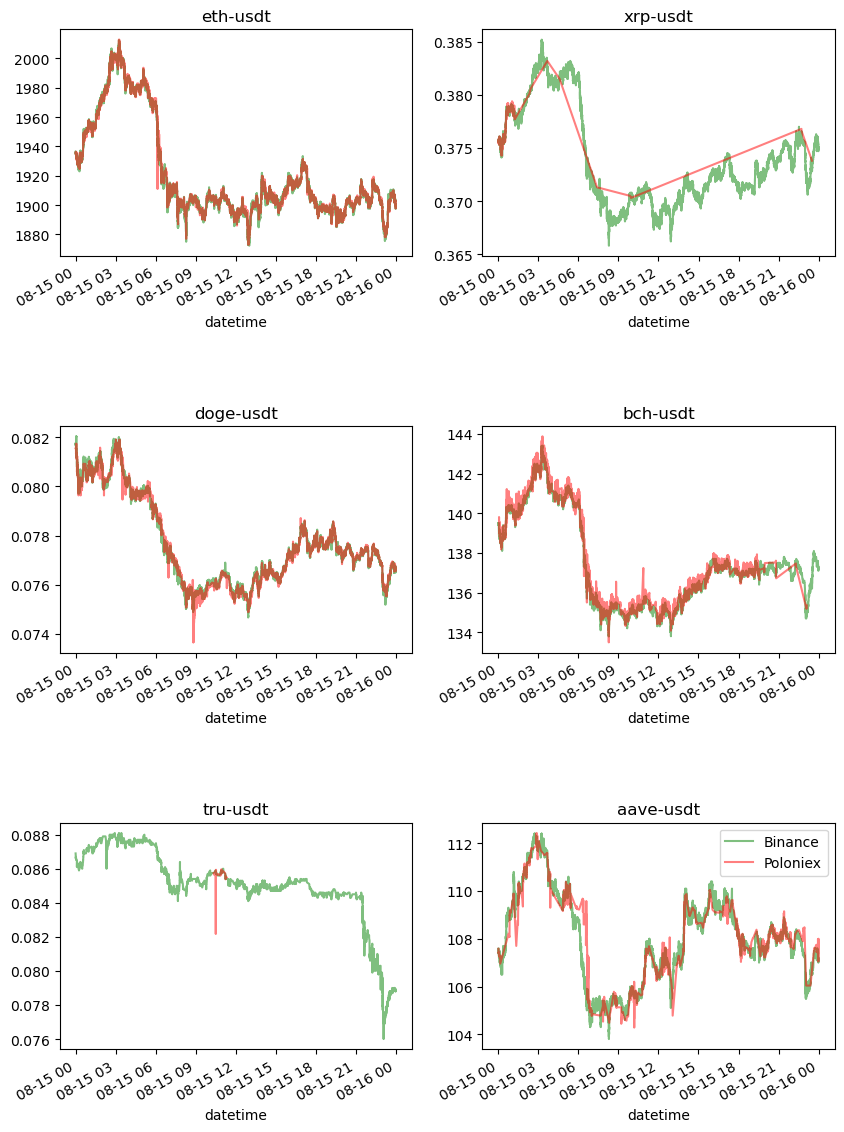

In [71]:
tickers_to_plot = ['eth-usdt', 'xrp-usdt', 'doge-usdt', 'bch-usdt', 'tru-usdt', 'aave-usdt']  
# ignore btc-usdt since it takes too long to plot

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# unpack all the axes subplots
axs = axs.ravel()

for idx in range(len(tickers_to_plot)):
    ticker = tickers_to_plot[idx]
    
    bnce = trades[(trades.instrmnt == ticker) & (trades.exchange == 'bnce')]
    polo = trades[(trades.instrmnt == ticker) & (trades.exchange == 'polo')]
    
    bnce.price.plot(ax=axs[idx], color='g', alpha=0.5, label="Binance")  # Alpha is used to make line transparent
    polo.price.plot(ax=axs[idx], color='r', alpha=0.5, label="Poloniex")
    axs[idx].set_title(f"{ticker}")

fig.subplots_adjust(hspace=0.75)  # add space between plots
plt.legend(loc="best")

### Other Visualizations
* Try graphing the price and volume for a single ticker, to see visually if volume on one exchange may affect price differentials. 
  * For example, create a subplot with 3 rows and 1 column - the first row graphs price, second row graphs volume on Binance, and third row graphs volume on Poloniex.

Other visualizations may also be helpful. Apart from using Matplotlib, the libraries Plotly and/or Seaborn may also be helpful for some visualizations.

## Numerical Analysis

#### 2.1: Does Arbitrage Exist?
First we can resample the data to some time interval (i.e. 1 second) based on the volume weighted average price (VWAP), and then calculate the percent price differential between poloniex and binance. Note that Poloniex only updates trades every second, which is why I chose the 1s interval. Otherwise, we could pick a smaller interval like ~0.1s which closer reflects the speed at which arbitrage opportunities may disappear in cryptocurrency markets.

Recall that VWAP is equal to the (sum of (price * volume)) / total units traded. The column `vol_dllr` contains the price * volume, so we only need to resample to `1s` aggregating using the sum() function, and then divide by the `amount` column to get the VWAP. 

It may be interesting to graph the price differentials in a histogram to see their distributions.

In [75]:
# Example: resampling doge prices to a 1 second interval VWAP price

# Filter for doge-usdt on binance
bnce_doge = trades[(trades.instrmnt == "doge-usdt") & (trades.exchange == 'bnce')]

# Calculate the VWAP
bnce_doge = bnce_doge.resample("1s").sum(numeric_only = True)
bnce_doge["vwap"] = bnce_doge.vol_dllr / bnce_doge.amount

# Drop invalid columns after resampling using sum
bnce_doge.drop(columns=["price", "sell2"], inplace=True)

bnce_doge

,time,amount,vol_dllr,vwap
datetime,,,,
2022-08-15 00:00:00,1.660522e+12,6405.0,523.16040,0.081680
2022-08-15 00:00:01,0.000000e+00,0.0,0.00000,NaN
2022-08-15 00:00:02,1.660522e+12,302.0,24.66434,0.081670
2022-08-15 00:00:03,0.000000e+00,0.0,0.00000,NaN
2022-08-15 00:00:04,1.660522e+12,16111.0,1315.78537,0.081670
...,...,...,...,...
2022-08-15 23:59:50,1.660608e+12,7103.0,544.37392,0.076640
2022-08-15 23:59:51,0.000000e+00,0.0,0.00000,NaN
2022-08-15 23:59:52,6.642432e+12,21767.0,1668.12386,0.076635


In [ ]:
polo_doge = ...

<AxesSubplot:title={'center':'Binance doge-usdt VWAP price, 1s interval'}, xlabel='datetime'>

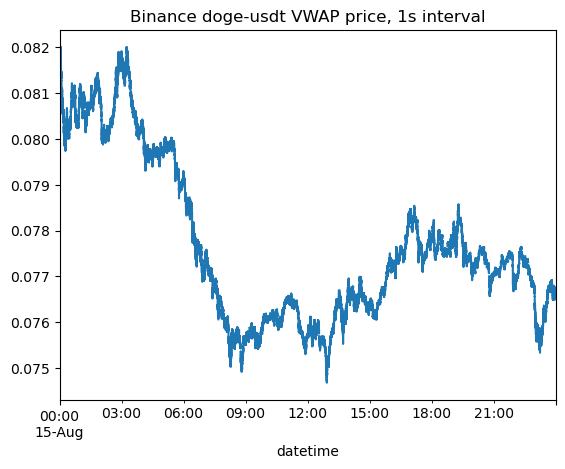

In [80]:
bnce_doge.vwap.plot(title="Binance doge-usdt VWAP price, 1s interval")

<AxesSubplot:title={'center':'Binance doge-usdt all trade prices'}, xlabel='datetime'>

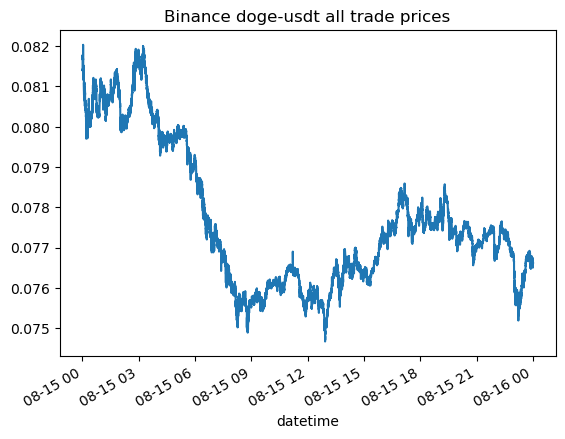

In [81]:
trades[(trades.instrmnt == "doge-usdt") & (trades.exchange == 'bnce')].price.plot(
    title="Binance doge-usdt all trade prices"
)

#### 2.2: The Duration of Arbitrage
Given a price differential greater than some value, how long does it take for the price differential to disappear?

#### 2.3: Driving Factors of Arbitrage
One way to start off is by calculating some indicators like volume, change in volume, change in price, etc. and see if they influence the availability of arbitrage opportunities (i.e. the size of arbitrage opportunities that we calculated in 2.1). 

You can graph the variables side by side to check for visual driving factors, use correlation to check for a linear relationship, or use spearman correlation to check for a rank relationship (i.e. whether a higher rank of some variable corresponds to a higher rank of arbitrage opportunity).

It may also be interesting to only look at the top quintile of arbitrage opportunities to see which variables can predict large opportunities (which are the ones we care about)

## Discussion

### Limitations
Poloniex data seems to be updated every second, so the trade times aren't exact. You may want to download data for another exchange (see download.ipynb) and take a look at those 

What other limitations / challenges are there to executing the arbitrage?